In [1]:
from keras import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense, TimeDistributed
import matplotlib.dates as mdates

In [2]:
import utils
import autoregression as ar
import neural_network as nn

In [3]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 14
MEDIUM = 16
LARGE = 20
THICK = 4
THIN = 3
WIDE_FIG = (20,7.5)
TWO_TIMES_TWO = (20,15)
SMALL_FIG = (6,6)
OPACITY = .25


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THIN)

plt.rc('font', size=SMALL, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
temperatureX = utils.parse_file('data/pcu2/Supply trafo A winding 2U temp.csv', 'tempX')
temperatureY = utils.parse_file('data/pcu2/Supply trafo A winding 2V temp.csv', 'tempY')
temperatureZ = utils.parse_file('data/pcu2/Supply trafo A winding 2W temp.csv', 'tempZ')
auxiliaries = utils.parse_file('data/pcu1/AUX ON from PCU.csv', 'aux')
current = utils.parse_file('data/pt4/i1.csv', 'I')

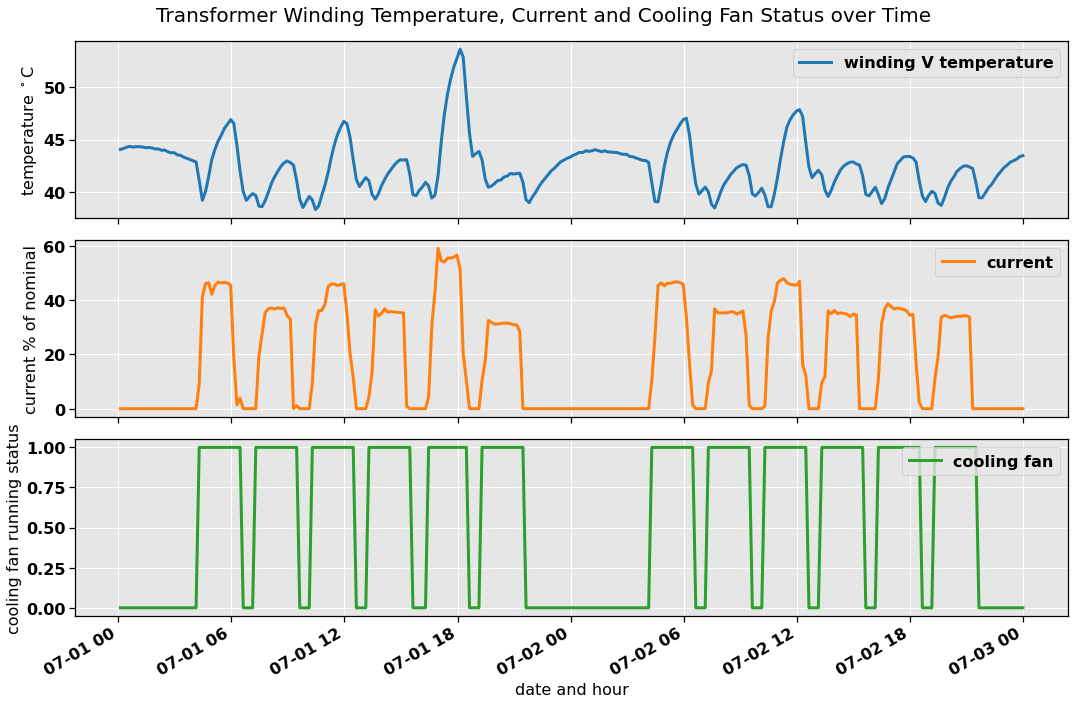

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10), sharex=True)
fig.suptitle('Transformer Winding Temperature, Current and Cooling Fan Status over Time', fontsize=LARGE)

temp_name = 'tempY'
operation = utils.align(auxiliaries, current, temperatureY)
start='2018-07-01 00:00:00'
end='2018-07-03 00:00:00'

ax = axes[0]
operation[temp_name][start:end].plot(ax=ax, label='winding V temperature')
ax.set_ylabel('temperature $^\circ$C')
ax.legend(loc='upper right')

ax = axes[1]
(operation['I'] / 630 * 100)[start:end].plot(ax=ax, color=COLORS[1], label='current')
ax.set_ylabel('current % of nominal')
ax.legend(loc='upper right')

ax = axes[2]
operation['aux_on'][start:end].plot(ax=ax, color=COLORS[2], label='cooling fan')
ax.set_ylabel('cooling fan running status')
ax.set_xlabel('date and hour')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

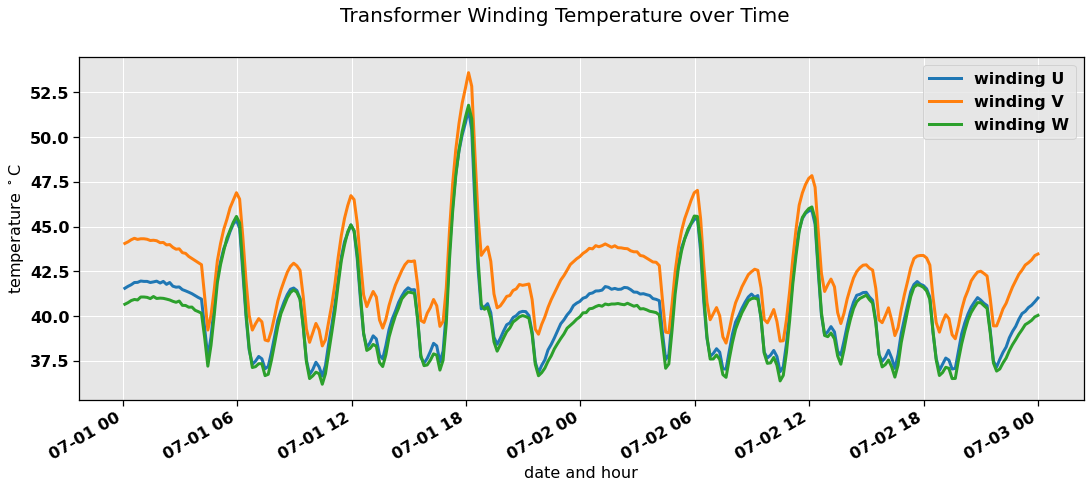

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18,7))
fig.suptitle('Transformer Winding Temperature over Time', fontsize=LARGE)

start='2018-07-01 00:00:00'
end='2018-07-03 00:00:00'

ax = axes
temperatureX[start:end].plot(ax=ax)
temperatureY[start:end].plot(ax=ax)
temperatureZ[start:end].plot(ax=ax)
ax.set_xlabel('date and hour')
ax.set_ylabel('temperature $^\circ$C')
ax.legend(['winding U', 'winding V', 'winding W'])

plt.show()

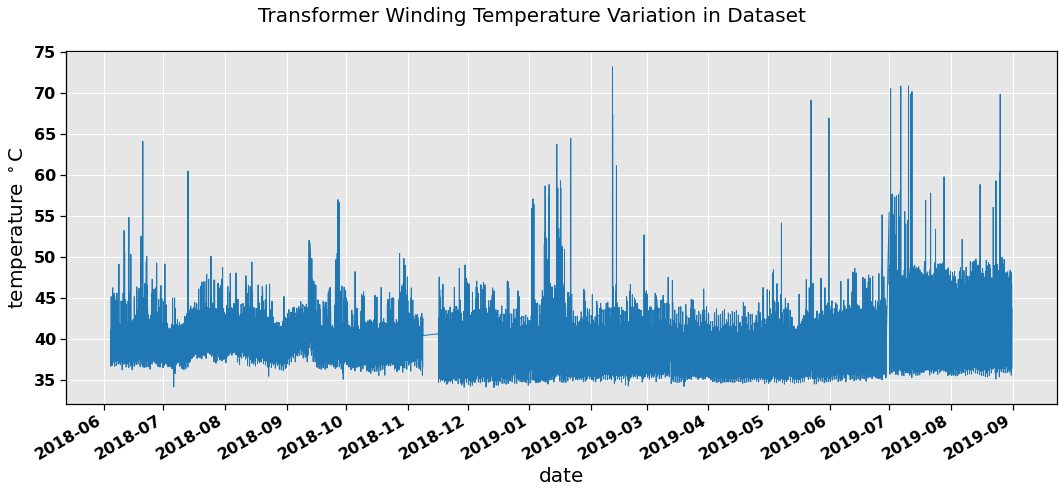

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
fig.suptitle('Transformer Winding Temperature Variation in Dataset', fontsize=LARGE)

ax = axes
temperatureX.plot(ax=ax, lw=1)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_ylabel('temperature $^\circ$C', fontsize=LARGE)
ax.get_legend().remove()
ax.set_xlabel('date', fontsize=LARGE)

plt.tight_layout()
plt.show()

In [133]:
X = utils.align(temperatureX, auxiliaries, current)

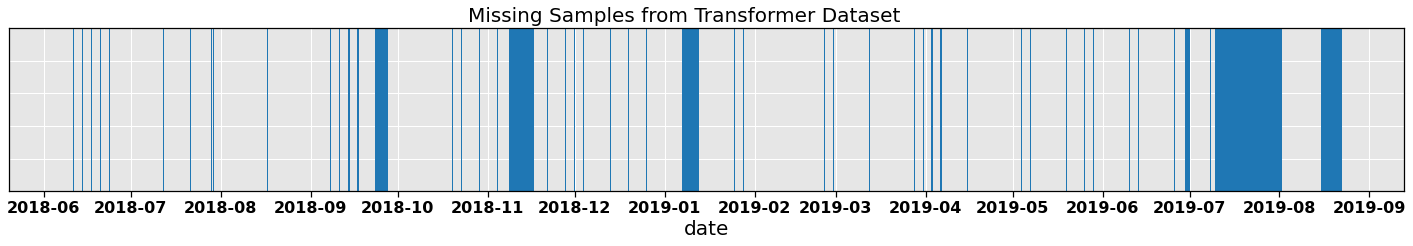

In [144]:
missing_samples = utils.sample_gaps(X)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,3))
fig.suptitle('Missing Samples from Transformer Dataset', fontsize=LARGE)

ax = axes
ax.eventplot(positions=missing_samples, orientation='horizontal', lw=1)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_ylim(.6,.7)
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.set_xlabel('date', fontsize=LARGE)

plt.show()

In [5]:
X, y = ar.prep_relative_model_dataset(temperatureX, temperatureY, temperatureZ, 1)
X.head(1)

,tempY,tempZ,temp__1
2018-06-04 12:20:00,42.114899,40.219727,41.15358


In [225]:
X, y = ar.prep_overall_model_dataset(auxiliaries, current, temperatureX, 5)
X.head(0)

,aux,intercept,I2,temp__1,temp__2,temp__3,temp__4,temp__5


In [46]:
max_shift = 9
results = np.ndarray((max_shift+1,5))
for i, shift in enumerate(range(max_shift+1)):
    X, y = ar.prep_overall_model_dataset(auxiliaries, current, temperatureX, shift)
    
    start='2018-11-15 00:00:00'
    end='2018-12-15 00:00:00'
    X_train, y_train = X[start:end], y[start:end]

    start='2019-01-07 00:00:00'
    end='2019-02-01 00:00:00'
    X_test, y_test = X[start:end], y[start:end]

    coeffs = ar.ols(X_train, y_train)

    t0 = y_train['tempX'][0]
    y_pred = ar.evaluate(coeffs, X_train, t0)
    r2_train = skl.metrics.r2_score(y_train, y_pred)
    mse_train = skl.metrics.mean_squared_error(y_train, y_pred)

    t0 = y_test['tempX'][0]
    y_pred = ar.evaluate(coeffs, X_test, t0)
    r2_test = skl.metrics.r2_score(y_test, y_pred)
    mse_test = skl.metrics.mean_squared_error(y_test, y_pred)

    results[i] = [shift, r2_train, mse_train, r2_test, mse_test]

results_df = DataFrame(data=results[:,1:], index=results[:,0].astype(np.int32), columns=['r2_train', 'mse_train', 'r2_test', 'mse_test'])

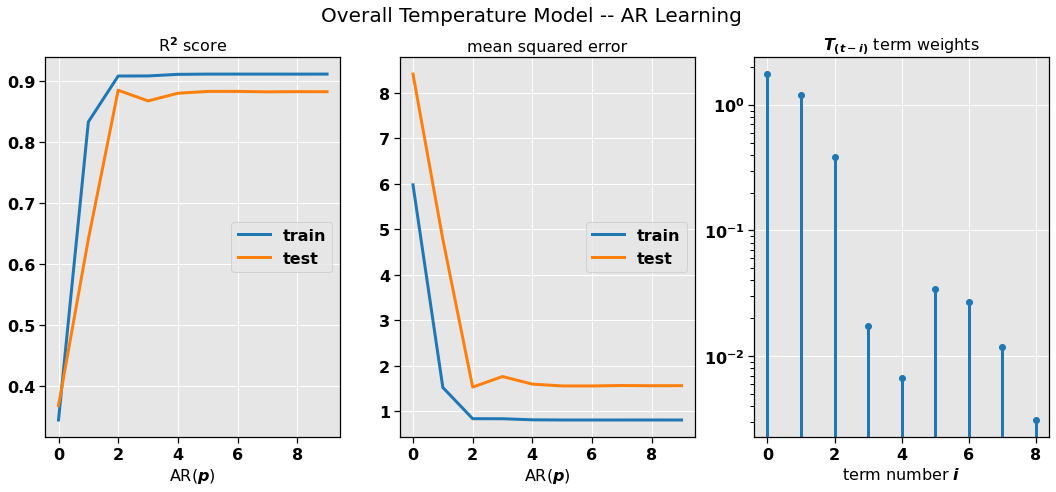

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
fig.suptitle('Overall Temperature Model -- AR Learning', fontsize=LARGE)

ax = axes[0]
results_df['r2_train'].plot(ax=ax)
results_df['r2_test'].plot(ax=ax)
ax.set_title('R$^2$ score')
ax.legend(['train', 'test'], loc='center right')
ax.set_xlabel(r'AR($p$)')

ax = axes[1]
results_df['mse_train'].plot(ax=ax)
results_df['mse_test'].plot(ax=ax)
ax.set_title('mean squared error')
ax.legend(['train', 'test'], loc='center right')
ax.set_xlabel(r'AR($p$)')

ax = axes[2]
ax.stem(abs(coeffs.iloc[:,3:].to_numpy().reshape(-1)))
ax.set_yscale('log')
ax.set_title('$T_{(t-i)}$ term weights')
ax.set_xlabel(r'term number $i$')

plt.show()

train: R2=0.909, MSE=8.347e-01
pred:  R2=0.885, MSE=1.529e+00


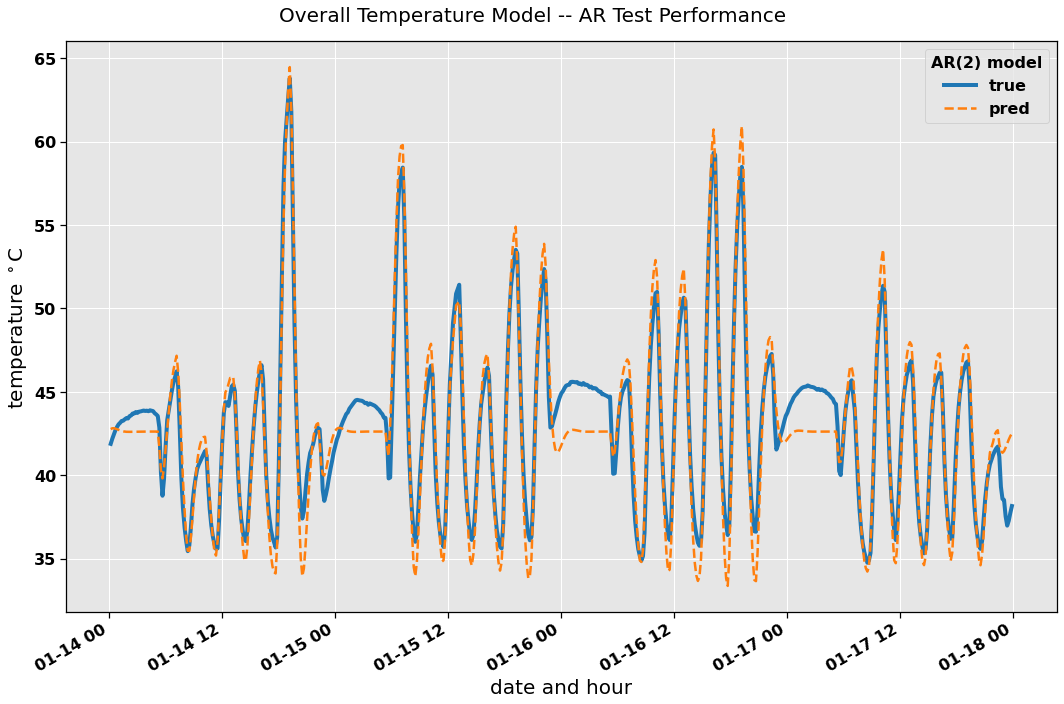

,aux,intercept,I2,temp__1,temp__2
0,-0.951064,5.378708,0.000015,1.480407,-0.606635


In [51]:
X, y = ar.prep_overall_model_dataset(auxiliaries, current, temperatureX, 2)

start='2018-11-15 00:00:00'
end='2018-12-15 00:00:00'

X_train, y_train = X[start:end], y[start:end]

start='2019-01-07 00:00:00'
end='2019-02-01 00:00:00'

X_test, y_test = X[start:end], y[start:end]

coeffs = ar.ols(X_train, y_train)

t0 = y_train['tempX'][0]
y_pred = ar.evaluate(coeffs, X_train, t0)

r2 = skl.metrics.r2_score(y_train, y_pred)
mse = skl.metrics.mean_squared_error(y_train, y_pred)
print(f'train: R2={r2:.3f}, MSE={mse:.3e}')

t0 = y_test['tempX'][0]
y_pred = ar.evaluate(coeffs, X_test, t0)

r2 = skl.metrics.r2_score(y_test, y_pred)
mse = skl.metrics.mean_squared_error(y_test, y_pred)
print(f'pred:  R2={r2:.3f}, MSE={mse:.3e}')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
fig.suptitle('Overall Temperature Model -- AR Test Performance', fontsize=LARGE)

ax = axes
start='2019-01-14 00:00:00'
end='2019-01-18 00:00:00'
y_test[start:end].plot(ax=ax, lw=4)
y_pred[start:end].plot(ax=ax, lw=2.5, style='--')
ax.set_ylabel('temperature $^\circ$C', fontsize=LARGE)
ax.set_xlabel('date and hour', fontsize=LARGE)

ax.legend(['true', 'pred'], title='AR(2) model', title_fontsize=MEDIUM)

plt.tight_layout()
plt.show()

coeffs

In [8]:
X, y = nn.prep_overall_model_dataset(auxiliaries, current, temperatureX)
X.head(0)

,aux,I2


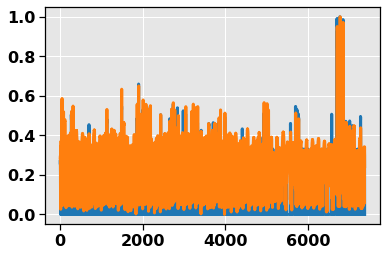

In [9]:
start='2018-11-15 00:00:00'
end='2019-01-07 00:00:00'
X_train, y_train = X[start:end], y[start:end]

X_scaler = skl.preprocessing.MinMaxScaler()
X_scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)

ymin, ymax = y_train.min()[0], y_train.max()[0]
y_scaler = skl.preprocessing.MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)

plt.plot(X_train_scaled[:,1])
plt.plot(y_train_scaled[:,0])
plt.show()

In [10]:
def new_rnn(sample_size, p):
    model = Sequential([
        LSTM(30, return_sequences=True, input_shape=(sample_size, p), dropout=.0, recurrent_dropout=.5, unroll=True),
        LSTM(18, return_sequences=True, unroll=True),
        Dense(sample_size)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [11]:
n, p = X_train_scaled.shape
sample_size_max = 10
sample_size_rng = range(1, sample_size_max+1)
models = dict()
Xs = dict()
ys = dict()

for sample_size in sample_size_rng:
    model = new_rnn(sample_size, p)
    models[sample_size] = model
    
    X_train_reshaped, y_train_reshaped = nn.reshape_seq_to_seq(X_train_scaled, y_train_scaled, sample_size)
    Xs[sample_size] = X_train_reshaped
    ys[sample_size] = y_train_reshaped
    
    
#model.summary()

In [12]:
epochs = 50
batch_size = 50

for sample_size in sample_size_rng:
    print(f'sample_size={sample_size}')
    model = models[sample_size]
    X_train_reshaped, y_train_reshaped = Xs[sample_size], ys[sample_size]
    model.fit(X_train_reshaped, y_train_reshaped, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=False)

sample_size=1
sample_size=2
sample_size=3
sample_size=4
sample_size=5
sample_size=6
sample_size=7
sample_size=8
sample_size=9
sample_size=10


In [52]:
start='2019-01-07 00:00:00'
end='2019-02-01 00:00:00'

X_test, y_test = X[start:end], y[start:end]
test_indexes = X_test.index

X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

results = np.ndarray((sample_size_max,5))
for i, sample_size in enumerate(sample_size_rng):
    model = models[sample_size]
    X_train_reshaped, y_train_reshaped = Xs[sample_size], ys[sample_size]
    X_test_reshaped, y_test_reshaped = nn.reshape_seq_to_seq(X_test_scaled, y_test_scaled, sample_size)
    
    y_pred_raw = model.predict(X_train_reshaped)
    y_pred = y_pred_raw[:,-1,0].reshape(-1,1)
    y_pred = y_pred*(ymax - ymin) + ymin
    shift = 1
    y_true = y_train[sample_size-shift:-1*shift if shift else None]
    r2_train = skl.metrics.r2_score(y_true, y_pred)
    mse_train = skl.metrics.mean_squared_error(y_true, y_pred)
    
    y_pred_raw = model.predict(X_test_reshaped)
    y_pred = y_pred_raw[:,-1,0].reshape(-1,1)
    y_pred = y_pred*(ymax - ymin) + ymin
    y_true = y_test[sample_size-shift:-1*shift if shift else None]

    r2_test = skl.metrics.r2_score(y_true, y_pred)
    mse_test = skl.metrics.mean_squared_error(y_true, y_pred)
    
    results[i] = [sample_size, r2_train, mse_train, r2_test, mse_test]

results_df = DataFrame(data=results[:,1:], index=results[:,0].astype(np.int32), columns=['r2_train', 'mse_train', 'r2_test', 'mse_test'])

ValueError: operands could not be broadcast together with shapes (2809,5) (2,) (2809,5) 

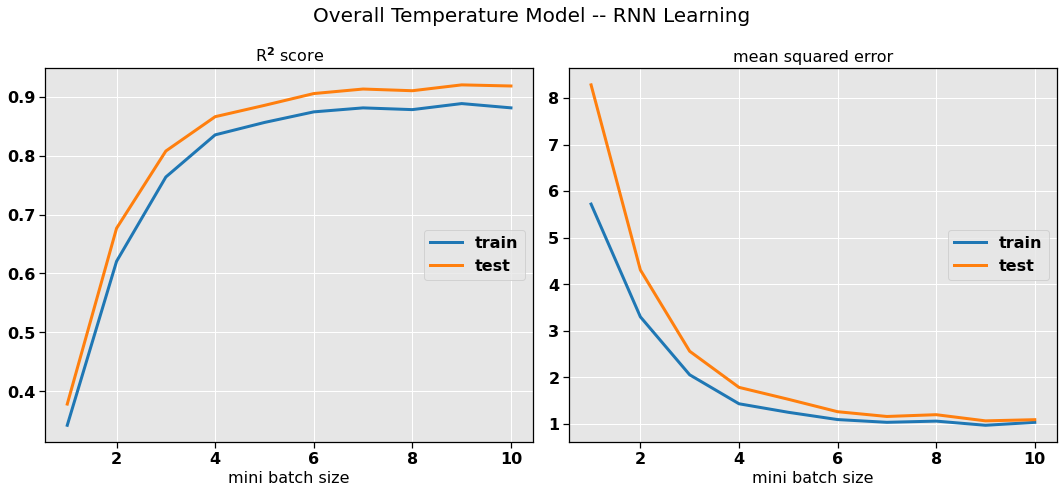

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
fig.suptitle('Overall Temperature Model -- RNN Learning', fontsize=LARGE)

ax = axes[0]
results_df['r2_train'].plot(ax=ax)
results_df['r2_test'].plot(ax=ax)
ax.set_title('R$^2$ score')
ax.legend(['train', 'test'], loc='center right')
ax.set_xlabel(r'mini batch size')

ax = axes[1]
results_df['mse_train'].plot(ax=ax)
results_df['mse_test'].plot(ax=ax)
ax.set_title('mean squared error')
ax.legend(['train', 'test'], loc='center right')
ax.set_xlabel(r'mini batch size')

plt.tight_layout()
plt.show()

In [34]:
start='2018-11-15 00:00:00'
end='2018-12-15 00:00:00'

#start='2018-12-15 00:00:00'
end='2019-02-01 00:00:00'

X_test, y_test = X[start:end], y[start:end]
test_indexes = X_test.index

X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

sample_size = 9
model = models[sample_size]
X_test_reshaped, y_test_reshaped = nn.reshape_seq_to_seq(X_test_scaled, y_test_scaled, sample_size)

y_pred_raw = model.predict(X_test_reshaped)
y_pred = y_pred_raw[:,-1,0].reshape(-1,1)
y_pred = y_pred*(ymax - ymin) + ymin
shift = 1
y_true = y_test[sample_size-shift:-1*shift if shift else None]

r2 = skl.metrics.r2_score(y_true, y_pred)
mse = skl.metrics.mean_squared_error(y_true, y_pred)
print(f'test:  R2={r2:.3f}, MSE={mse:.3e}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
y_pred_df = DataFrame(data=y_pred, index=test_indexes[sample_size-shift:-1*shift if shift else None])
y_true_df = DataFrame(data=y_true, index=test_indexes[sample_size-shift:-1*shift if shift else None])

ax = axes[0]
y_true_df.plot(ax=ax, lw=2)
y_pred_df.plot(ax=ax, lw=2.5, style=':', rot=0)
ax.legend(['true', 'pred'])
ax.set_ylabel('temperature $^\circ$C')

ax = axes[1]
start='2019-01-14 00:00:00'
end='2019-01-18 00:00:00'
y_true_df[start:end].plot(ax=ax)
y_pred_df[start:end].plot(ax=ax, rot=0)
ax.legend(['true', 'pred'])

ax.set_ylabel('temperature $^\circ$C')
ax.set_xlabel('date and time')

plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (10186,5) (2,) (10186,5) 

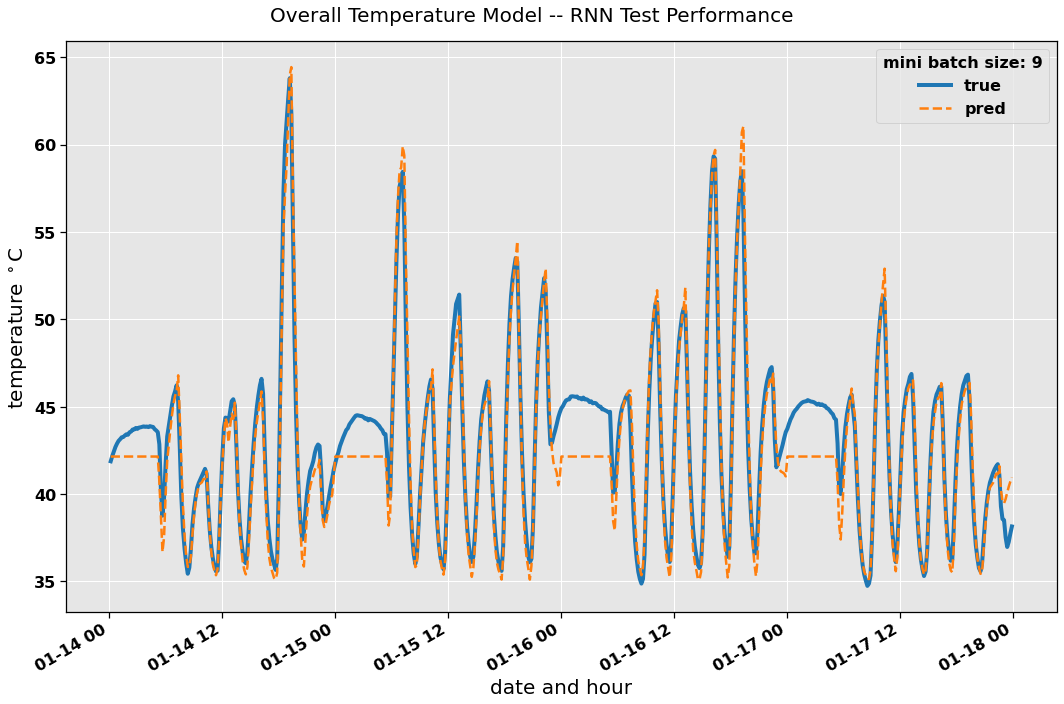

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
fig.suptitle('Overall Temperature Model -- RNN Test Performance', fontsize=LARGE)

ax = axes
start='2019-01-14 00:00:00'
end='2019-01-18 00:00:00'
y_true_df[start:end].plot(ax=ax, lw=4)
y_pred_df[start:end].plot(ax=ax, lw=2.5, style='--')
ax.set_ylabel('temperature $^\circ$C', fontsize=LARGE)
ax.set_xlabel('date and hour', fontsize=LARGE)

ax.legend(['true', 'pred'], title='mini batch size: 9', title_fontsize=MEDIUM)

plt.tight_layout()
plt.show()

In [35]:
y_pred_df.var()

0    8.759937
dtype: float32

In [36]:
y_true_df.var()

tempX    10.04884
dtype: float64

In [37]:
y_train.var()

tempX    9.125779
dtype: float64

In [42]:
y_test['2018-11-16 00:00:00':'2019-01-07 00:00:00'].var()

tempX    8.703581
dtype: float64

In [45]:
y_test['2019-01-07 00:00:00':None].var()

tempX    13.325702
dtype: float64